In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')
try:
    os.chdir("drive/My Drive/PROJEKT/")
except FileNotFoundError:
    pass


Mounted at /content/drive/


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
import numpy as np
from definitions import *
from new_preprocessing import load_datasets, time_footprint, load_labels_datasets, load_images_datasets
import tensorflow as tf
from tensorflow import keras

### Load data sets

In [ ]:
#train_ds, test_ds, val_ds = test_load_datasets()
SMALL_BATCH_SIZE = 128
train_ds, test_ds, val_ds = load_datasets(batch_size=SMALL_BATCH_SIZE)

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


### Load model

In [ ]:
model_path = 'models/task_2a_2e-52021-01-14_15-40-33_acc_0.9027.h5'

In [ ]:
model = keras.models.load_model(model_path)
# summarize the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Set layer.trainable for two last layers
for layer in model.layers[12:16]:
    layer.trainable = True

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# updatable plot for live loss value observation
# a minimal example (sort of)
from IPython.display import clear_output

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
#         self.accuracy.append(logs.get('binary_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
#         plt.plot(self.x, self.accuracy, label="accuracy")
        plt.legend()
        plt.show();
        
plot = PlotLosses()

In [ ]:
base_learning_rate = 2.0e-5
print(model.output_shape)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss = keras.losses.CategoricalCrossentropy(),
              metrics   = ['accuracy'])

(None, 4)


In [ ]:
TRAIN_FILES//SMALL_BATCH_SIZE

553

### Train 3 last layers

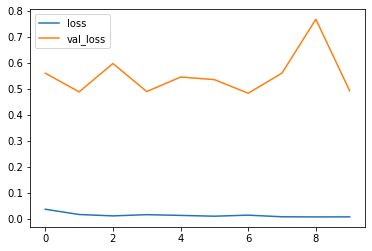

In [ ]:
epochs          = 10
steps_per_epoch = TRAIN_FILES//SMALL_BATCH_SIZE
val_steps       =   VAL_FILES//SMALL_BATCH_SIZE

LOG_DIR = 'logs'
MODEL_DIR = 'models'

time_fp = time_footprint()
log_dir = os.path.join(LOG_DIR, 'task_2b', time_fp)
os.makedirs(log_dir)

checkpoint_path = log_dir + "/task_2b_2e-5" + time_fp + ".ckpt"

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                       save_weights_only=False,
                                       verbose=1,
                                       save_best_only=True,
                                       monitor='val_loss'),
    plot
]

print(train_ds)
print(val_ds)
history = model.fit(train_ds,
                    epochs           = epochs,
                    steps_per_epoch  = steps_per_epoch,
                    validation_data  = val_ds,
                    validation_steps  = val_steps,
                    callbacks        = callbacks
                    )


val_acc = history.history['val_accuracy'][0]

model_name = "task_2b_2e-5" + time_fp + '_acc_' + f'{val_acc:.4f}' + '.h5'
model.save(MODEL_DIR + '/' + model_name)

In [ ]:
MODEL_DIR = 'models'
model_name = "task_2b2e-5.h5"
model.save(MODEL_DIR + '/' + model_name)

In [ ]:
#additional packages added
time_fp = time_footprint()
from __future__ import absolute_import, division, print_function, unicode_literals
import math

#computing accuracy
steps_test = TEST_FILES//SMALL_BATCH_SIZE
loss, acc = model.evaluate(test_ds, steps = steps_test)


#preparing predictions
predictions = model.predict(test_ds, verbose=1, steps = None)

172/172 [==============================] - 105s 612ms/step


In [ ]:
print(predictions)

[[1.0000000e+00 4.0878162e-18 0.0000000e+00 2.0371025e-23]
 [1.9289598e-18 1.0000000e+00 0.0000000e+00 2.2956996e-26]
 [1.7441266e-14 3.5418742e-15 1.0000000e+00 6.6778316e-13]
 ...
 [1.0000000e+00 2.1187908e-10 0.0000000e+00 1.2657487e-16]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [1.1009447e-07 9.9999988e-01 0.0000000e+00 3.4591850e-12]]


In [ ]:
# Prepare smaller data set
# 50 batches

test_labels = []

for images, labels in test_ds.as_numpy_iterator(): 

  labels = labels.argmax(axis=1)
  test_labels.append(labels)


In [ ]:
test_labels = np.concatenate(test_labels)

In [ ]:
predictions_classes = predictions.argmax(axis=1)
predictions_classes[0]

0

In [ ]:
import sklearn
import sklearn.metrics

# Confusion matrix for SVM with linear kernel
sklearn.metrics.confusion_matrix(test_labels, predictions_classes)

array([[5379,   70,    1,   91],
       [ 121, 4885,   14,  269],
       [  31,   11, 4887,   71],
       [ 202,  214,   18, 5685]])

In [ ]:
# Accuracy
sklearn.metrics.accuracy_score(test_labels, predictions_classes)

0.9492915394778806

In [ ]:
# Precision recall fscor support
sklearn.metrics.precision_recall_fscore_support(test_labels, predictions_classes, average="macro")

(0.9510310509832669, 0.9502129570538036, 0.9505114655826691, None)

In [ ]:
#load model from saved files in logs
model2 = tf.keras.models.load_model('logs/task_2a/2021-01-13_23-03-57/task_2a_2021-01-13_23-03-57.ckpt')
loss2, acc2 = model2.evaluate(test_ds, steps = 85)
predictions2 = model2.predict(test_ds, verbose=1, steps = None)
test_labels2 = []

for images, labels in test_ds.as_numpy_iterator(): 

  labels = labels.argmax(axis=1)
  test_labels2.append(labels)

test_labels2 = np.concatenate(test_labels2)
predictions_classes2 = predictions2.argmax(axis=1)


In [ ]:
# Confusion matrix for SVM with linear kernel
print(sklearn.metrics.confusion_matrix(test_labels2, predictions_classes2))
# Accuracy
print(sklearn.metrics.accuracy_score(test_labels2, predictions_classes2))
# Precision recall fscor support
print(sklearn.metrics.precision_recall_fscore_support(test_labels2, predictions_classes2, average="macro"))

[[5247  133    6  155]
 [ 139 4825   15  310]
 [  12    9 4887   92]
 [ 267  440   74 5338]]
0.9247346120552189
(0.9262549612801612, 0.9272441253701847, 0.9266153664650884, None)
